In [2]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


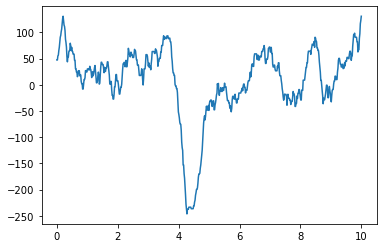

In [3]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [4]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [5]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
#print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


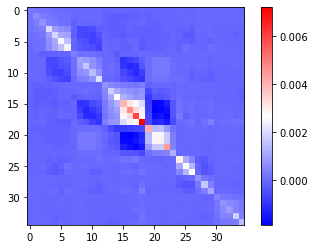

In [6]:
show_heat_map(dm.P_avg_train)

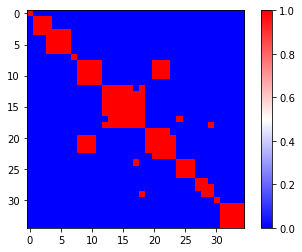

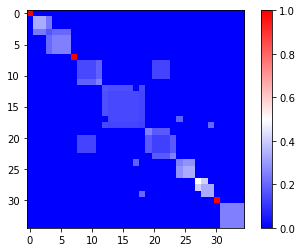

In [7]:
n = 2.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

In [8]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 512,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 64], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}

In [10]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, Araw)

  0%|          | 0/6 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu


 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]

 33%|███▎      | 2/6 [00:03<00:07,  1.99s/it]

 50%|█████     | 3/6 [00:05<00:05,  1.99s/it]

 67%|██████▋   | 4/6 [00:08<00:04,  2.02s/it]

100%|██████████| 6/6 [00:10<00:00,  1.73s/it]

Epoch: 1   Batch: 6 of size 512   Train loss: 589.3998413085938   Valid loss: 589.06201171875
----------Training Ends-----------
----------Training GDE-----------



  0%|          | 0/21 [00:00<?, ?it/s]

device set to cpu


  5%|▍         | 1/21 [00:03<01:07,  3.37s/it]

 10%|▉         | 2/21 [00:06<01:04,  3.38s/it]

 14%|█▍        | 3/21 [00:10<01:01,  3.41s/it]

 19%|█▉        | 4/21 [00:13<00:57,  3.36s/it]

 24%|██▍       | 5/21 [00:16<00:53,  3.34s/it]

 29%|██▊       | 6/21 [00:20<00:50,  3.36s/it]

 33%|███▎      | 7/21 [00:23<00:46,  3.32s/it]

 38%|███▊      | 8/21 [00:26<00:43,  3.32s/it]

 43%|████▎     | 9/21 [00:30<00:39,  3.30s/it]

 48%|████▊     | 10/21 [00:33<00:36,  3.32s/it]

 52%|█████▏    | 11/21 [00:36<00:32,  3.27s/it]

 57%|█████▋    | 12/21 [00:39<00:29,  3.31s/it]

 62%|██████▏   | 13/21 [00:43<00:26,  3.36s/it]

 67%|██████▋   | 14/21 [00:46<00:23,  3.30s/it]

 71%|███████▏  | 15/21 [00:49<00:19,  3.32s/it]

 76%|███████▌  | 16/21 [00:53<00:16,  3.37s/it]

 81%|████████  | 17/21 [00:56<00:13,  3.32s/it]

 86%|████████▌ | 18/21 [00:59<00:09,  3.33s/it]

 90%|█████████ | 19/21 [01:03<00:06,  3.35s/it]

 95%|█████████▌| 20/21 [01:06<00:03,  3.28s/it]

100%|██████████| 21/21 [01:06<00:00,  3.18s/it]

Epoch: 1   Batch: 21 of size 128   Train loss: 558.228759765625   Valid loss: 556.8832397460938
----------Training Ends-----------


----------Training MLP-----------


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.291 ----------saved-----------
0.504 ----------saved-----------
0.646 ----------saved-----------
0.678 ----------saved-----------
0.687 ----------saved-----------
0.693 ----------saved-----------
0.697 ----------saved-----------
0.699 ----------saved-----------
0.703 ----------saved-----------
0.712 ----------saved-----------
0.719 ----------saved-----------
0.731 ----------saved-----------
0.732 ----------saved-----------
0.737 ----------saved-----------
0.741 ----------saved-----------
0.742 ----------saved-----------
0.745 ----------saved-----------
0.745 ----------saved-----------
0.747 ----------saved-----------
0.751 ----------saved-----------
0.359 ----------saved-----------
0.368 ----------saved-----------
0.398 ----------saved-----------
0.424 ----------saved-----------
0.424 ----------saved-----------
0.433 ----------saved-----------
0.466 ----------saved-----------
0.51 ----------saved-----------
0.523 ----------saved-----------
0.531 ----------saved-----------
0.56 ------

In [15]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.1666 F1 accuracy 0.425 Precision accuracy 0.279 Recall accuracy 0.898 AUC accuracy: 0.926
device set to cuda
threshold: 0.1  validation loss: 0.1666 F1 accuracy 0.566 Precision accuracy 0.421 Recall accuracy 0.864 AUC accuracy: 0.926
device set to cuda
threshold: 0.15  validation loss: 0.1666 F1 accuracy 0.654 Precision accuracy 0.544 Recall accuracy 0.82 AUC accuracy: 0.926
device set to cuda
threshold: 0.2  validation loss: 0.1666 F1 accuracy 0.702 Precision accuracy 0.631 Recall accuracy 0.79 AUC accuracy: 0.926
device set to cuda
threshold: 0.25  validation loss: 0.1666 F1 accuracy 0.722 Precision accuracy 0.694 Recall accuracy 0.753 AUC accuracy: 0.926
device set to cuda
threshold: 0.3  validation loss: 0.1666 F1 accuracy 0.745 Precision accuracy 0.758 Recall accuracy 0.732 AUC accuracy: 0.926
device set to cuda
threshold: 0.35  validation loss: 0.1666 F1 accuracy 0.751 Precision accuracy 0.803 Recall accuracy 0.